In [94]:
import cv2
import itertools
import numpy as np
from ultralytics import YOLO
import supervision as sv
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.rc(
    'figure',
    figsize=(12, 8),
)


In [95]:
model = YOLO("yolov8x.pt")
frame_generator = sv.get_video_frames_generator("vehicles.mp4")

index = 40
frame = next(itertools.islice(frame_generator, index, None))

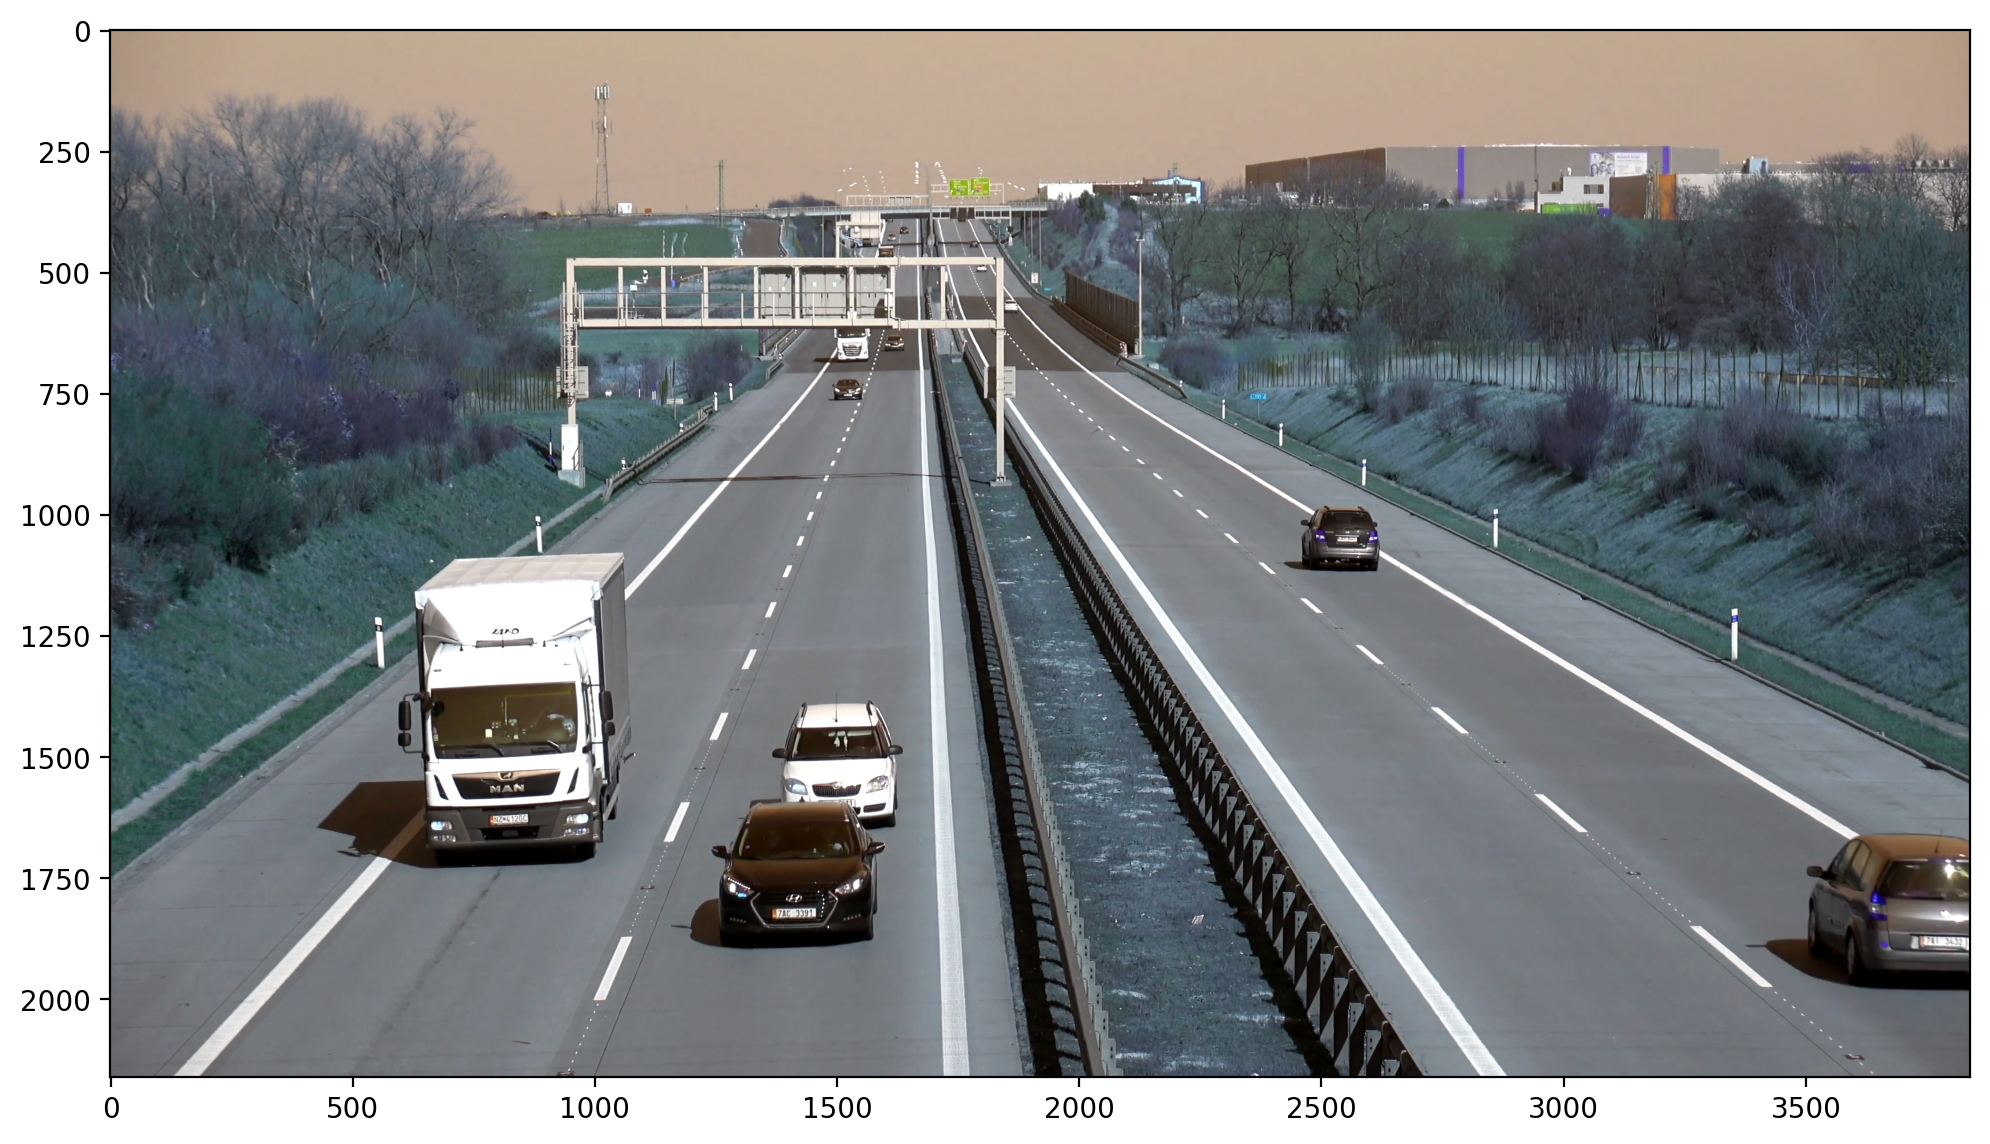

In [96]:
plt.imshow(frame)

In [97]:
results = model(frame, device='mps')[0]
detections = sv.Detections.from_ultralytics(results)


0: 384x640 5 cars, 2 trucks, 49.1ms
Speed: 4.3ms preprocess, 49.1ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)


3.391304347826087
3.4347826086956523


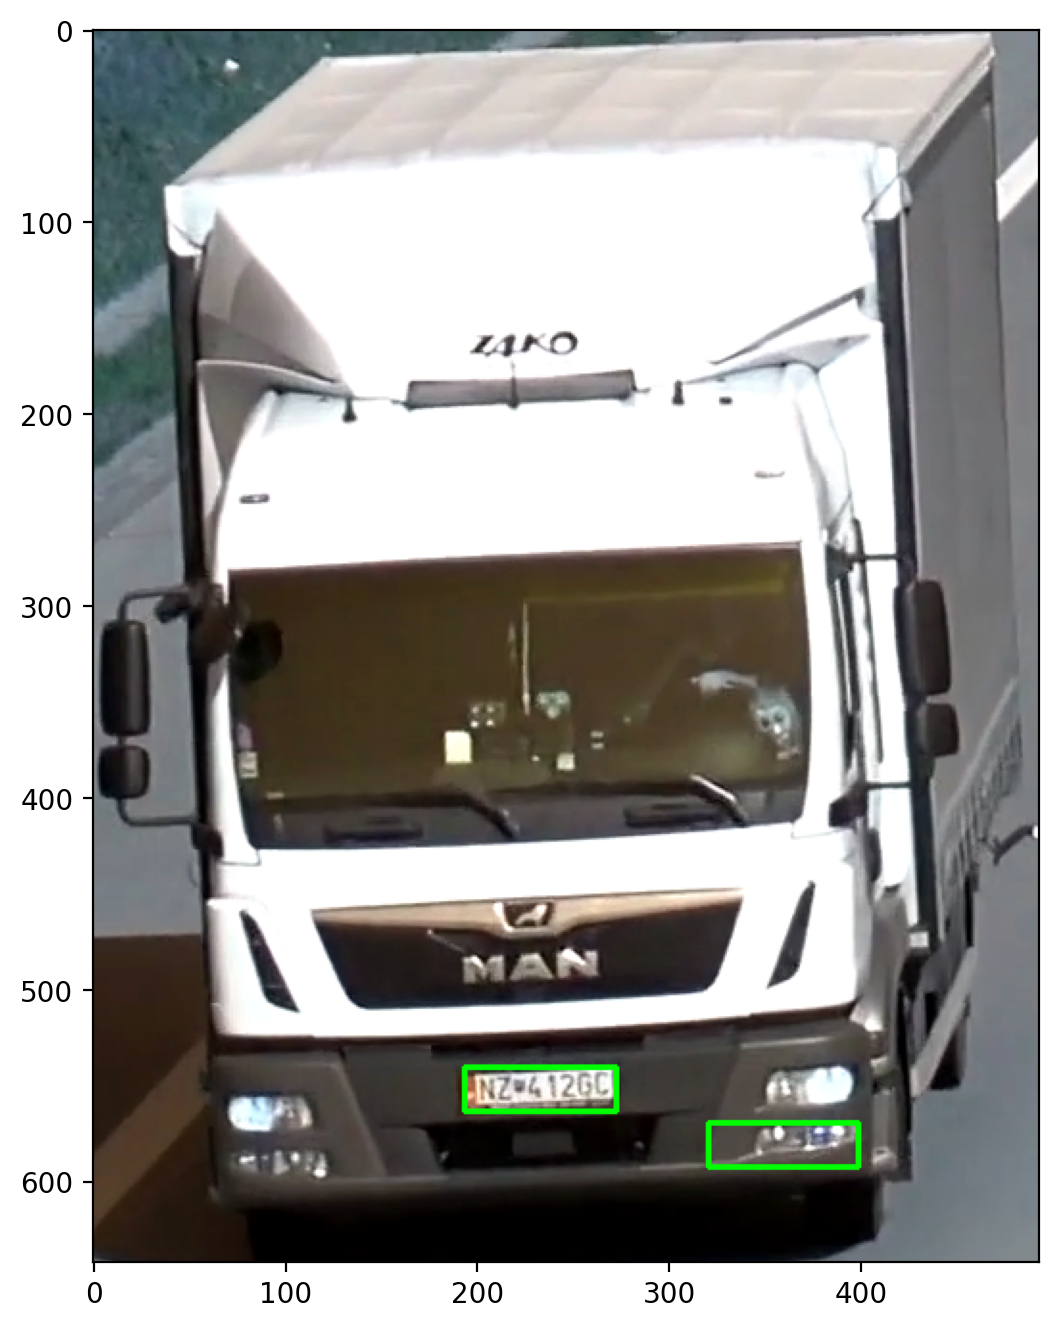

In [196]:
x1,y1,x2,y2 = detections[0].xyxy.astype(np.int32).tolist()[0]

roi = frame.copy()[y1:y2, x1:x2]

roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

res, mask = cv2.threshold(roi_gray, 100, 255, cv2.THRESH_BINARY)

def mask_contours(mask, function):
    mask = mask.copy()
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_to_remove = filter(lambda c: function(c), contours)
    contours_to_remove = list(contours_to_remove)
    return cv2.drawContours(mask, contours_to_remove, -1, (0, 0, 0), -1)

mask = mask_contours(mask, lambda c: cv2.contourArea(c) < 500)
mask = mask_contours(mask, lambda c: cv2.contourArea(c) > 2000)
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    aspect_ratio = w / h
    if 2.5 < aspect_ratio < 4.5:
        print(aspect_ratio)
        cv2.rectangle(roi, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.imshow(roi, cmap="gray")